# Crypto Market Prediction — Feature Engineering & Modeling

This notebook focuses on transforming raw signals and engineered indicators into predictive features, training a model on them, and evaluating performance based on the competition’s target metric: **Pearson correlation** between predictions and true labels.

---

**Pipeline Structure:**
1. Load pre-processed data
2. Feature engineering
3. Train/validation split (time-aware)
4. Model training (baseline → optimized)
5. Evaluation: Pearson correlation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

from catboost import CatBoostRegressor, Pool

import warnings
warnings.filterwarnings("ignore")

## Load EDA-ready Data

In [2]:
train = pd.read_parquet("data/train.parquet", engine="pyarrow")
df = pd.read_parquet("data/train.parquet", engine="pyarrow")

train.index = pd.to_datetime(train.index)
df.index = pd.to_datetime(df.index)
train = train.sort_index()
df = df.sort_index()
train.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X772,X773,X774,X775,X776,X777,X778,X779,X780,label
2023-03-01 00:00:00,15.283,8.425,176.405,44.984,221.389,0.181844,-0.637860,0.006652,0.136870,0.116698,...,0.333753,-0.009992,-0.695595,-0.444077,-0.191238,-0.184251,-0.471897,-0.625428,-0.553991,0.562539
2023-03-01 00:01:00,38.590,2.336,525.846,321.950,847.796,0.489497,-0.075619,0.431594,0.522400,0.475255,...,0.333657,-0.010040,-0.696226,-0.452866,-0.200082,-0.188929,-0.472842,-0.625832,-0.554426,0.533686
2023-03-01 00:02:00,0.442,60.250,159.227,136.369,295.596,0.260121,-0.444684,0.100695,0.224729,0.203282,...,0.333667,-0.010037,-0.696832,-0.461383,-0.208786,-0.193571,-0.473785,-0.626236,-0.554860,0.546505
2023-03-01 00:03:00,4.865,21.016,335.742,124.963,460.705,0.099976,-0.666728,-0.123858,0.019197,0.014459,...,0.333174,-0.010279,-0.697391,-0.469628,-0.217350,-0.198175,-0.474726,-0.626639,-0.555294,0.357703
2023-03-01 00:04:00,27.158,3.451,98.411,44.407,142.818,0.270893,-0.325973,0.116336,0.234311,0.214073,...,0.333171,-0.010283,-0.697940,-0.477622,-0.225780,-0.202745,-0.475666,-0.627043,-0.555728,0.362452


In [3]:
print(train.isna().sum().sort_values(ascending=False).head(10))

label      0
bid_qty    0
X765       0
X764       0
X763       0
X762       0
X761       0
X760       0
X759       0
X758       0
dtype: int64


## Feature Engineering

In [ ]:
# train['buy_pressure'] = train['buy_qty'] / (train['buy_qty'] + train['sell_qty'] + 1e-5)
# train['bid_ask_ratio'] = train['bid_qty'] / (train['bid_qty'] + train['ask_qty'] + 1e-5)

# train['volume_rolling_mean_10'] = train['volume'].shift(1).rolling(10).mean()
# train['buy_pressure_rolling_std_10'] = train['buy_pressure'].shift(1).rolling(10).std()
# train['rolling_mean_5'] = train['volume'].shift(1).rolling(5).mean()

# train['log_volume'] = np.log1p(train['volume'])
# train['delta_bid_ask'] = train['bid_qty'] - train['ask_qty']
# train['order_imbalance'] = (train['bid_qty'] - train['ask_qty']) / (train['bid_qty'] + train['ask_qty'] + 1e-5)
# train['volatility_5'] = train['volume'].shift(1).rolling(5).std()

# train['buy_pressure_x_bidask'] = train['buy_pressure'] * train['bid_ask_ratio']
# train['volume_to_volatility'] = train['volume'] / (train['volatility_5'] + 1e-5)

# train['label_lag1'] = train['label'].shift(1)
# train['return_lag1'] = train['label_lag1'] - train['label_lag1'].shift(1)

In [5]:
df['liq_imbalance'] = (df['bid_qty'] - df['ask_qty']) / (df['bid_qty'] + df['ask_qty'] + 1e-5)
df['order_pressure'] = df['buy_qty'] - df['sell_qty']
df['aggressiveness'] = (df['buy_qty'] + df['sell_qty']) / (df['bid_qty'] + df['ask_qty'] + 1e-5)
df['volatility_5'] = df['volume'].rolling(5, min_periods=1).std()
df['mean_pressure_3'] = (df['buy_qty'] - df['sell_qty']).rolling(3, min_periods=1).mean()

In [6]:
train.dropna(inplace=True)
# df.dropna(inplace=True)

In [ ]:
X_cols = [col for col in df.columns if col.startswith("X")]
X_data = df[X_cols]
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca_features = pca.fit_transform(X_data)
for i in range(10):
    df[f'pca_{i}'] = pca_features[:, i]

In [ ]:
# from catboost import CatBoostRegressor
# from sklearn.model_selection import train_test_split
# from scipy.stats import pearsonr

# # Features to use
# features = ['liq_imbalance', 'order_pressure', 'aggressiveness', 'volatility_5', 'mean_pressure_3'] + \
#            [f'pca_{i}' for i in range(10)]

# X = df[features].fillna(0)
# y = df['label']

# X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.1)

# model = CatBoostRegressor(
#     iterations=3000,
#     learning_rate=0.01,
#     depth=8,
#     loss_function='MAE',
#     eval_metric='MAE',
#     early_stopping_rounds=200,
#     verbose=100,
#     random_seed=42,
#     task_type='CPU'
# )

# model.fit(
#     X_train, y_train,
#     eval_set=(X_val, y_val),
#     use_best_model=True
# )

# # Pearson на валидации
# from scipy.stats import pearsonr
# val_preds = model.predict(X_val)
# val_corr = pearsonr(val_preds, y_val)[0]
# print("Validation Pearson Correlation:", val_corr)

0:	learn: 0.6302824	test: 0.7129970	best: 0.7129970 (0)	total: 205ms	remaining: 10m 14s
100:	learn: 0.6217953	test: 0.7092899	best: 0.7092899 (100)	total: 5.7s	remaining: 2m 43s
200:	learn: 0.6166978	test: 0.7084658	best: 0.7084489 (191)	total: 10.9s	remaining: 2m 31s
300:	learn: 0.6127069	test: 0.7084253	best: 0.7083603 (247)	total: 16s	remaining: 2m 23s
400:	learn: 0.6093670	test: 0.7084875	best: 0.7082895 (346)	total: 21.1s	remaining: 2m 16s
500:	learn: 0.6066475	test: 0.7085121	best: 0.7082895 (346)	total: 26.2s	remaining: 2m 10s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7082895104
bestIteration = 346

Shrink model to first 347 iterations.
Validation Pearson Correlation: 0.0721124027071477


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split


X_cols = [col for col in df.columns if col.startswith("X")]
X = df[X_cols]
y = df["label"]


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


model = CatBoostRegressor(verbose=100, iterations=500, early_stopping_rounds=50)
model.fit(X_train, y_train, eval_set=(X_val, y_val))


importances = model.get_feature_importance()
feature_scores = pd.Series(importances, index=X.columns).sort_values(ascending=False)

top_features = feature_scores.head(50).index.tolist()
print(top_features)


Learning rate set to 0.200673
0:	learn: 0.9989381	test: 1.0012998	best: 1.0012998 (0)	total: 298ms	remaining: 2m 28s
100:	learn: 0.7339254	test: 0.7415929	best: 0.7415929 (100)	total: 25.6s	remaining: 1m 41s
200:	learn: 0.6061887	test: 0.6175772	best: 0.6175772 (200)	total: 49.5s	remaining: 1m 13s
300:	learn: 0.5219721	test: 0.5358874	best: 0.5358874 (300)	total: 1m 13s	remaining: 48.7s
400:	learn: 0.4610993	test: 0.4771497	best: 0.4771497 (400)	total: 1m 37s	remaining: 24.1s
499:	learn: 0.4164863	test: 0.4345756	best: 0.4345756 (499)	total: 2m 1s	remaining: 0us

bestTest = 0.4345756415
bestIteration = 499

['X758', 'X780', 'X613', 'X757', 'X611', 'X769', 'X344', 'X466', 'X752', 'X683', 'X608', 'X777', 'X425', 'X750', 'X772', 'X174', 'X778', 'X779', 'X445', 'X508', 'X421', 'X614', 'X576', 'X428', 'X385', 'X751', 'X501', 'X343', 'X610', 'X337', 'X591', 'X180', 'X612', 'X759', 'X285', 'X383', 'X415', 'X96', 'X684', 'X219', 'X588', 'X169', 'X178', 'X198', 'X181', 'X341', 'X97', 'X589', 'X

In [12]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

model = CatBoostRegressor(
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    iterations=1000,
    early_stopping_rounds=100,
    verbose=100
)

model.fit(X_train[top_features], y_train, eval_set=(X_val[top_features], y_val))
y_pred = model.predict(X_val[top_features])

# Pearson
pearson = pearsonr(y_val, y_pred)[0]
print(f"Validation Pearson Correlation: {pearson:.4f}")

0:	learn: 1.0079377	test: 1.0092761	best: 1.0092761 (0)	total: 44.5ms	remaining: 44.4s
100:	learn: 0.9291534	test: 0.9331492	best: 0.9331492 (100)	total: 4.01s	remaining: 35.7s
200:	learn: 0.8804966	test: 0.8846539	best: 0.8846539 (200)	total: 7.8s	remaining: 31s
300:	learn: 0.8446849	test: 0.8488407	best: 0.8488407 (300)	total: 11.5s	remaining: 26.8s
400:	learn: 0.8126154	test: 0.8168993	best: 0.8168993 (400)	total: 15.3s	remaining: 22.8s
500:	learn: 0.7842067	test: 0.7889847	best: 0.7889847 (500)	total: 19.1s	remaining: 19.1s
600:	learn: 0.7583205	test: 0.7633527	best: 0.7633527 (600)	total: 22.9s	remaining: 15.2s
700:	learn: 0.7342236	test: 0.7394157	best: 0.7394157 (700)	total: 26.7s	remaining: 11.4s
800:	learn: 0.7118189	test: 0.7176631	best: 0.7176631 (800)	total: 30.6s	remaining: 7.6s
900:	learn: 0.6926589	test: 0.6990954	best: 0.6990954 (900)	total: 34.4s	remaining: 3.78s
999:	learn: 0.6751699	test: 0.6818078	best: 0.6818078 (999)	total: 38.3s	remaining: 0us

bestTest = 0.68180

## Train/Validation Split (Time-based)

In [ ]:
X = train.drop(columns=['label'])
y = train['label']

In [ ]:
cutoff_idx = int(len(train) * 0.9)
X_train, X_val = X.iloc[:cutoff_idx], X.iloc[cutoff_idx:]
y_train, y_val = y.iloc[:cutoff_idx], y.iloc[cutoff_idx:]

In [ ]:
print("Train:", X_train.shape)
print("Validation:", X_val.shape)

Train: (473288, 796)
Validation: (52588, 796)


In [ ]:
print([col for col in X_train.columns if 'label' in col])

[]


## Model Training — CatBoost Regressor

In [ ]:
# model = CatBoostRegressor(
#     iterations=2000,
#     learning_rate=0.01,
#     depth=8,
#     loss_function='MAE',         
#     eval_metric='MAE',           
#     early_stopping_rounds=1000,   
#     verbose=100,
#     random_seed=42,
#     task_type='CPU'
# )
# model.fit(
#     X_train, y_train,
#     eval_set=(X_val, y_val),
#     use_best_model=True
# )

0:	learn: 1.0043232	test: 1.0512040	best: 1.0512040 (0)	total: 2.5s	remaining: 2h 5m 11s
100:	learn: 0.9283288	test: 1.0512255	best: 1.0507857 (70)	total: 3m 46s	remaining: 1h 48m 20s
200:	learn: 0.8709245	test: 1.0521361	best: 1.0507857 (70)	total: 7m 25s	remaining: 1h 43m 20s
300:	learn: 0.8218874	test: 1.0553387	best: 1.0507857 (70)	total: 10m 50s	remaining: 1h 37m 11s
400:	learn: 0.7802890	test: 1.0556091	best: 1.0507857 (70)	total: 14m 21s	remaining: 1h 33m 3s
500:	learn: 0.7425269	test: 1.0579079	best: 1.0507857 (70)	total: 18m 7s	remaining: 1h 30m 22s
600:	learn: 0.7083073	test: 1.0606649	best: 1.0507857 (70)	total: 22m 5s	remaining: 1h 28m 11s
700:	learn: 0.6767518	test: 1.0628343	best: 1.0507857 (70)	total: 26m 19s	remaining: 1h 26m 21s
800:	learn: 0.6485344	test: 1.0654891	best: 1.0507857 (70)	total: 30m 32s	remaining: 1h 23m 49s
900:	learn: 0.6222754	test: 1.0686283	best: 1.0507857 (70)	total: 34m 39s	remaining: 1h 20m 45s
1000:	learn: 0.5987636	test: 1.0727453	best: 1.05078

## Validation Performance

In [ ]:
# val_preds = model.predict(X_val)

# corr, _ = pearsonr(val_preds, y_val)
# print(f"Validation Pearson Correlation: {corr:.5f}")

Validation Pearson Correlation: 0.06779


In [ ]:
# def evaluate_custom_model(train_df, feature_list, model_params, label_col='label', test_size=0.1, random_state=42):
#     from catboost import CatBoostRegressor
#     from sklearn.model_selection import train_test_split
#     from scipy.stats import pearsonr
#     import time

#     
#     df = train_df[feature_list + [label_col]].dropna()
#     X = df[feature_list]
#     y = df[label_col]

#     # Time-based split
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)

#     
#     model = CatBoostRegressor(**model_params)

#     
#     start = time.time()
#     model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
#     duration = time.time() - start

#     
#     val_preds = model.predict(X_val)
#     corr, _ = pearsonr(val_preds, y_val)

#     
#     print("=" * 60)
#     print(f"Features: {feature_list}")
#     print(f"Pearson Correlation: {corr:.5f}")
#     print(f"⏱Training time: {duration:.2f} sec")
#     print(f"Best iteration: {model.get_best_iteration()}")
#     print("=" * 60)

#     return corr, duration, model.get_best_iteration()

In [ ]:
# feature_list = [
#     'buy_pressure',
#     'bid_ask_ratio',
#     'volume_rolling_mean_10',
#     'buy_pressure_rolling_std_10',
#     'rolling_mean_5',
#     'log_volume',
#     'delta_bid_ask',
#     'order_imbalance',
#     'volatility_5',
#     'buy_pressure_x_bidask',
#     'volume_to_volatility'
# ]

In [ ]:
# model_params = {
#     'iterations': 2000,
#     'learning_rate': 0.01,
#     'depth': 8,
#     #'grow_policy': 'Lossguide',
#     #'min_data_in_leaf': 5,
#     'loss_function': 'MAE',
#     'eval_metric': 'MAE',
#     'early_stopping_rounds': 200,
#     #'l2_leaf_reg': 3,
#     'random_seed': 42,
#     'verbose': 100,
#     'task_type': 'CPU'
# }

In [ ]:
# evaluate_custom_model(train, feature_list, model_params)

## Another model

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train, y_train)
preds = ridge.predict(X_val)
print("Ridge Pearson:", np.corrcoef(preds, y_val)[0, 1])

Ridge Pearson: 0.08240077870100909


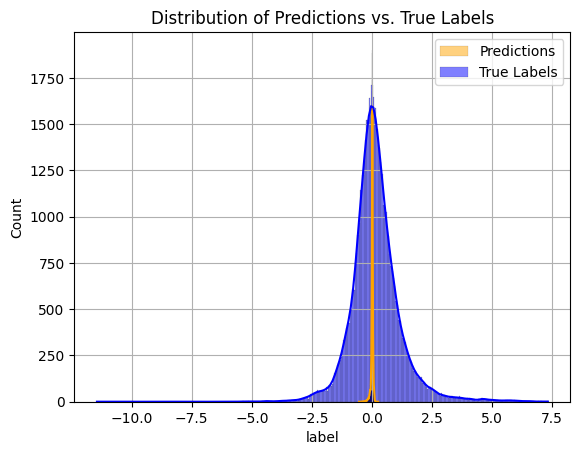

In [ ]:
sns.histplot(val_preds, kde=True, color='orange', label='Predictions')
sns.histplot(y_val, kde=True, color='blue', label='True Labels')
plt.legend()
plt.title("Distribution of Predictions vs. True Labels")
plt.grid(True)
plt.show()

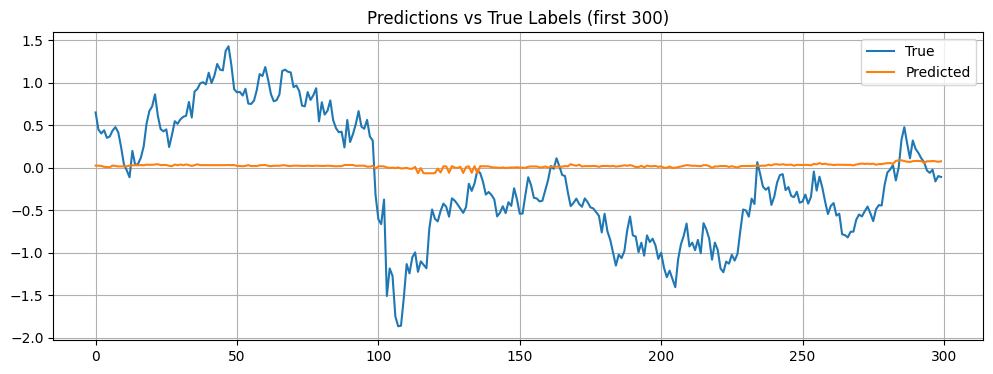

In [ ]:
import matplotlib.pyplot as plt

val_preds = model.predict(X_val)

plt.figure(figsize=(12, 4))
plt.plot(y_val.values[:300], label='True')
plt.plot(val_preds[:300], label='Predicted')
plt.legend()
plt.grid(True)
plt.title("Predictions vs True Labels (first 300)")
plt.show()

### Feature Importance

In [ ]:
importances = model.get_feature_importance(prettified=True)
importances.head(20)

,Feature Id,Importances
0,X466,7.167746
1,X613,3.377692
2,X778,3.251610
3,X282,3.126848
4,X752,2.931843
5,X758,2.856695
6,X198,2.711958
7,X682,2.387481
8,X169,2.293270
9,X385,2.279095


### Save the Model

In [ ]:
model.save_model("catboost_crypto_model.cbm")

## Summary

### Key Takeaways:

- Built initial signals like `buy_pressure`, `bid_ask_ratio`, and rolling features.
- Applied time-based validation split to simulate real-world scenario.
- CatBoost baseline achieved a Pearson correlation of ~0.10885.
- Next step: test inference and submission file in the final notebook.